## Introduction
This notebook demoes the gdgtm workflow, from gathering a collection of rasters, through their alignment and matching.

In the course of the demo we will:
1. Download a Raster from Chelsa and set it up as our Master Geotiff.
2. Download multiple rasters from OLM data sets
3. Align those rasters with the Chelsa data

In [1]:
import gdgtm
import os
import rasterio
import matplotlib.pyplot as plt

/home/pete/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Get a raster from Chelsa and transform it

This section is concerned with getting a raster (in this particular case from https://chelsa-climate.org/) and re-formatting it to ensure that it matches a set of specifications.

#### get_chelsa_data

This function is a Python wrapper for the RChelsa getChelsa function.

The function takes on the following arguments:
* parameter: the climate data of interest. Legitimate values can be found at: file:///home/pete/Downloads/chelsa_file_specification_bioclim_plus.pdf

* extent: what extent of the map do we want to download? Note that "as-is" Chelsa uses degrees and degree fractions within the WGS84 coordinate system. The function assumes that the edge locations are provided in the **WNES** order, which is the standard used throughout gdgtm.

* start_date, end_date: days marking the start and end of the interval for whicht he data are to be gathered.

* write_location: location to which the raster will get saved.

In [14]:
parameter = "tas"
extent = (5.7663, 47.9163, 10.5532, 45.6755)
start_date = "2023-1-1"
end_date = "2023-1-5"

gdgtm.get_chelsa_data(parameter, extent, start_date, end_date, 
                      write_location = '/home/pete/Documents/tests_and_vals/gdgtm/01_get_functions/chelsa_tas_raw.tif')


Driver: GTiff/GeoTIFF
Files: none associated
Size is 43200, 20880
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-180.000138888850017,83.999860415150010)
Pixel Size = (0.008333333300000,-0.008333333300000)
Metadata:
  activity_id=observation
  AREA_OR_POINT=Area
  cf_standard_name=air_temperature
  citation1=Karger, D.N., Conrad, O., Böhner, J., Kawohl, T., Kreft, H., Soria-Auza, R.W., Zimmermann, N.E., Linder, P., Kessler, M. (2017). Climatologies at high resolution fo

'Target .tiff exists'

Here we visualize the output raster using rasterio and matplotlib to confirm that the output raster indeed exists. We can see that the raster downloaded successfully.

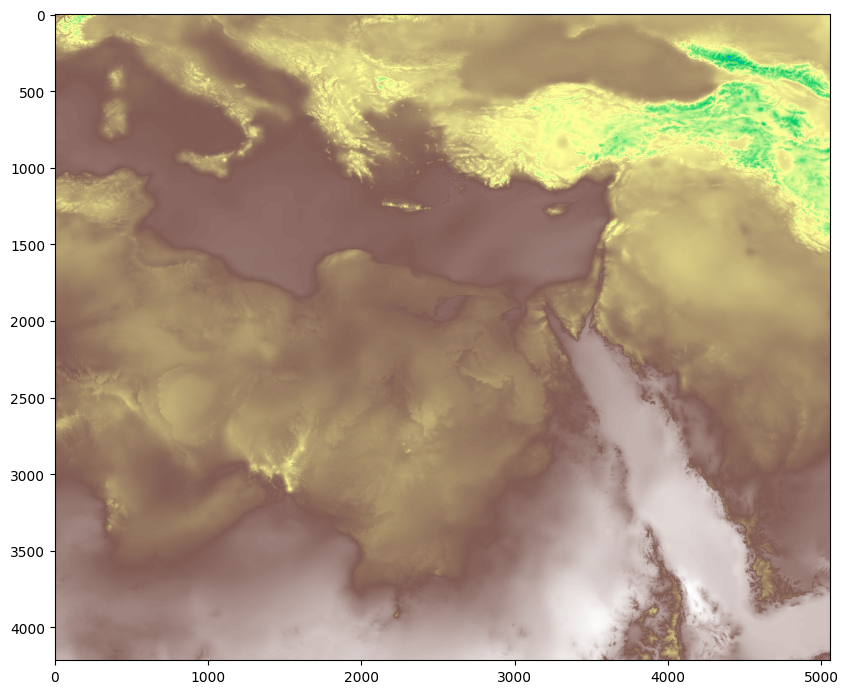

In [15]:
with rasterio.open("/home/pete/Documents/tests_and_vals/gdgtm/01_get_functions/chelsa_tas_raw.tif") as target:
    target_data = target.read()
    
    plt.figure(figsize=(10, 10))
    plt.imshow(target_data[0], cmap='terrain') # For single-band raster
    # plt.imshow(data.transpose(1, 2, 0)) # For multi-band raster
    plt.show()

#### Reproject raster

Here we move to reprojecting the raster from WGS84 to World_Cassini projection, chosen as it will give quite substantial visual deformation to the raster in question (thus allowing us to check that the function works).

Following arguments are required:
* new_crs: name of the new coordinate system that we want to reproject to. Uses the authority:number SRID format.
* source_raster: path and name of the file containing the raster that we want to reproject.
* dst_raster: path and name of the file where the raster will be saved after re-projection.

There is also an optional argument on whether to delete the source GeoTIFF, which is set by default to True if the output file is produced. This applies to all functions in the gdgtm package that ingest source rasters.


In [17]:
gdgtm.reproject_raster(new_crs = "ESRI:54028", 
                       source_raster = '/home/pete/Documents/tests_and_vals/gdgtm/01_get_functions/chelsa_tas_raw.tif',
                       dst_raster = '/home/pete/Documents/tests_and_vals/gdgtm/02_master_reprojected/chelsa_tas_reprojected.tif'
                      )

print("Source file retained: " + str(os.path.exists("/home/pete/Documents/tests_and_vals/gdgtm/01_get_functions/chelsa_tas_raw.tif")))


RasterioIOError: /home/pete/Documents/tests_and_vals/gdgtm/01_get_functions/chelsa_tas_raw.tif: No such file or directory

Here we visualize the re-projected raster. Note that with the ESRI:54028 (World_Cassini) projection, the raster became somewhat deformed, confirming that the function is working as intended.

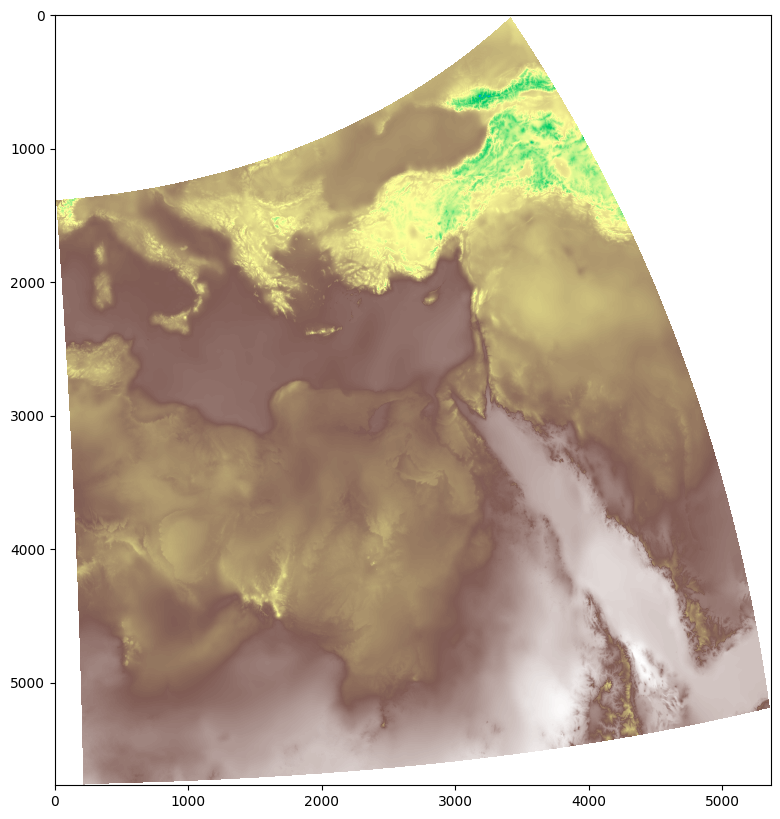

In [18]:
with rasterio.open("/home/pete/Documents/tests_and_vals/gdgtm/02_master_reprojected/chelsa_tas_reprojected.tif") as target:
    target_data = target.read()
    
    plt.figure(figsize=(10, 10))
    plt.imshow(target_data[0], cmap='terrain') # For single-band raster
    # plt.imshow(data.transpose(1, 2, 0)) # For multi-band raster
    plt.show()

#### change_raster_res

Here we aim to change the resolution of the raster in question. The function used, change_raster_res, is a rasterio wrapper, which requires three obligatory arguments:
* target_res: the new resolution we want to use - effectively the size of the edge of the pixel in real life. **This needs to be provided in the same units as the grid underpinning the raster** - so if the grid is set up in metres, the units provided need to be meters, and if the grid is set up in degrees, the units need to be provided in degrees.
* source and destination raster location, as was the case previously.

As a general rule, to limit the risk of artefacts occuring, raster resolution should take place after re-projection. The function uses Nearest Neighbour re-sampling implemented in GDAL.

In [19]:
gdgtm.change_raster_res(target_res = 5000,
                        source_raster = '/home/pete/Documents/tests_and_vals/gdgtm/02_master_reprojected/chelsa_tas_reprojected.tif',
                        dst_raster = '/home/pete/Documents/tests_and_vals/gdgtm/03_master_rescaled/chelsa_tas_rescaled.tif',
                       )

print("Source file retained: " + str(os.path.exists('/home/pete/Documents/tests_and_vals/gdgtm/02_ master_reprojected/chelsa_tas_reprojected.tif')))

Resolution change successful: new pixel size matches target
Source file retained: False


Here we visualize the data, seeing increased pixel size, thus confirming that the intended rescaling really happened. 

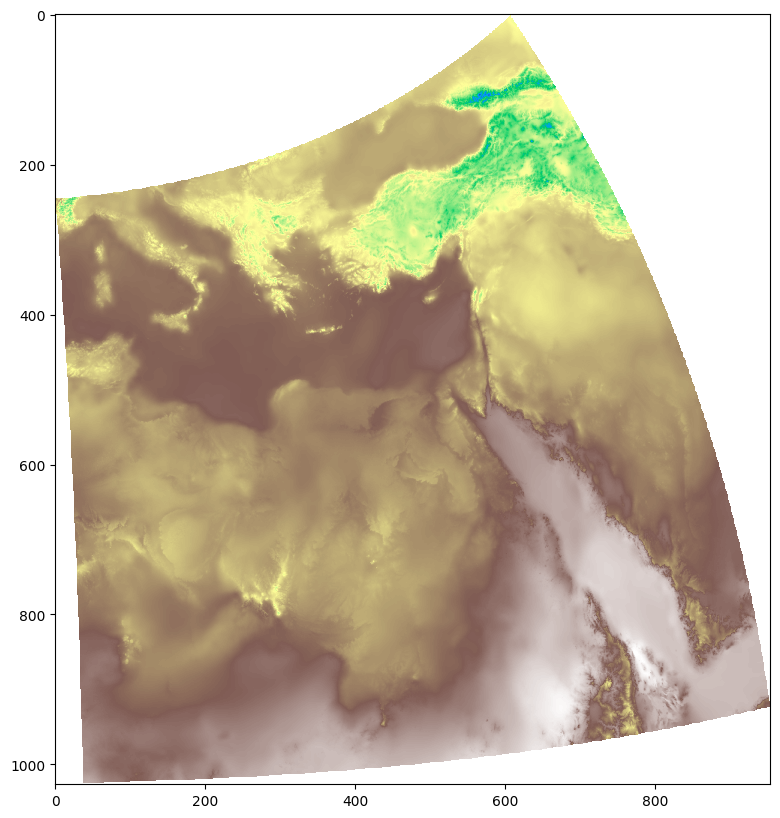

In [20]:
with rasterio.open("/home/pete/Documents/tests_and_vals/gdgtm/03_master_rescaled/chelsa_tas_rescaled.tif") as target:
    target_data = target.read()
    
    plt.figure(figsize=(10, 10))
    plt.imshow(target_data[0], cmap='terrain') # For single-band raster
    # plt.imshow(data.transpose(1, 2, 0)) # For multi-band raster
    plt.show()

#### set_raster_boundbox()

Now that the rasters have been re-projected and rescaled, we can set a new bounding box (i.e. "crop" the raster").

The function follows similar syntax to that already used elsewhere in this package, with the *target_bb* argument being a tuple of coordinates defining the West, North, East and South edges of the box coordinates.

Note that the automated file deletion will only take place when there is a good overlap between the intended bounding box and what GDAL (which this function really is just a wrapper for) could produce without introducing arbitrary offsets. In general, the higher the resolution, the smaller the change of the 1% check used to determine this being triggered and hence of the source not being deleted. The destination gets printed regardless.

In [8]:
new_bb = (515000, 5350000, 700000, 5100000)
gdgtm.set_raster_boundbox(target_bb = new_bb,
                          source_raster = "/home/pete/Documents/tests_and_vals/gdgtm/03_master_rescaled/chelsa_tas_rescaled.tif",
                          dst_raster = '/home/pete/Documents/tests_and_vals/gdgtm/04_master_rebound/chelsa_tas_rebound.tif',
                         )

print("Source file retained: " + str(os.path.exists('/home/pete/Documents/tests_and_vals/gdgtm/03_master_rescaled/chelsa_tas_rescaled.tif')))


Setting new bounding box successful: errors relative to target < 0.01
Source file retained: False


In the visualization we can see that the new bounding box got implemented.

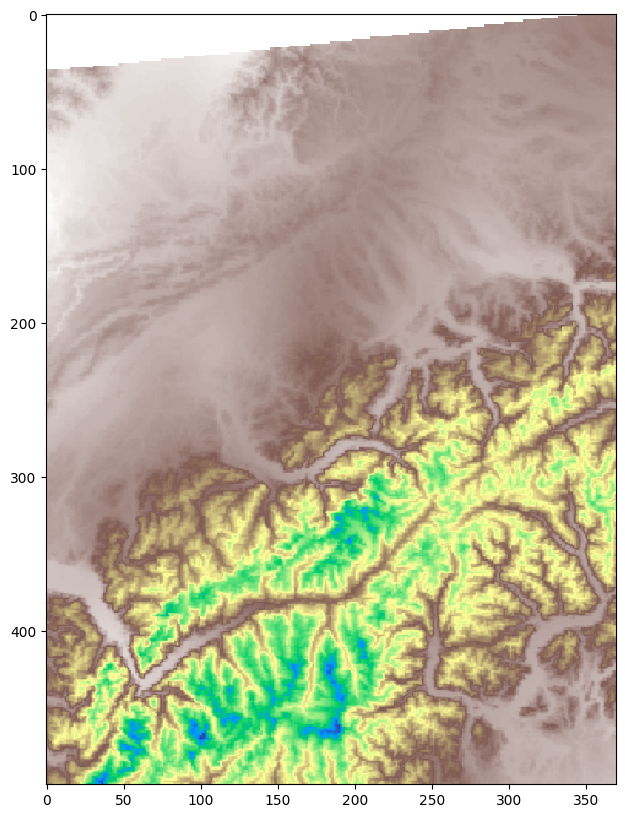

In [9]:
with rasterio.open("/home/pete/Documents/tests_and_vals/gdgtm/04_master_rebound/chelsa_tas_rebound.tif") as target:
    target_data = target.read()
    
    plt.figure(figsize=(10, 10))
    plt.imshow(target_data[0], cmap='terrain') # For single-band raster
    # plt.imshow(data.transpose(1, 2, 0)) # For multi-band raster
    plt.show()

### Get OLM rasters

Here we shall get some more resters from a different source: Open Land Map (OLM). 

Unlike Chelsa, which is unique in the way it structures and records information, OLM uses the STAC framework (https://stacspec.org/en/), meaning that, these function should be extendable across a range of static STAC contexts, which minimum amending.

#### get_cognames_from_stac_coll_static
The first thing to do is to get the names of the individual files (Cloud Optimized GeoTIFFs, or COGs). This is acheived by providing the get_cognames function the link to the collection .json file, which is a STAC standard file that contains, among other things, this ckind of information.

The function only requires a link to the collection.json file and returns a list of URLs to the relevant rasters.

In [10]:
hum_foot_url = gdgtm.get_cognames_from_stac_coll_static("https://s3.eu-central-1.wasabisys.com/stac/openlandmap/wilderness_li2022.human.footprint/collection.json")

In [11]:
alc_url = gdgtm.get_cognames_from_stac_coll_static("https://s3.eu-central-1.wasabisys.com/stac/openlandmap/land.cover_esacci.lc.l4/collection.json")

#### get_cogs_from_olm

In [24]:
bbox = (5.7663, 47.9163, 10.5532, 45.6755)

gdgtm.get_cogs_from_olm(cognames = hum_foot_url, 
                        target_directory = "/home/pete/Documents/tests_and_vals/gdgtm/01_get_functions/", 
                        target_names = "olm_humfoot_switz_raw_",
                        bbox = bbox,
                        interval = ("20020601", "20050101")
                       )

gdgtm.get_cogs_from_olm(cognames = alc_url, 
                        target_directory = "/home/pete/Documents/tests_and_vals/gdgtm/01_get_functions/", 
                        target_names = "olm_alc_switz_raw_",
                        bbox = bbox,
                        date_start = ("20020601", "20050101"),
                       )

/home/pete/Documents/tests_and_vals/gdgtm/01_get_functions/olm_humfoot_switz_raw_20030101.tif
/home/pete/Documents/tests_and_vals/gdgtm/01_get_functions/olm_humfoot_switz_raw_20040101.tif
/home/pete/Documents/tests_and_vals/gdgtm/01_get_functions/olm_alc_switz_raw_20030101.tif
/home/pete/Documents/tests_and_vals/gdgtm/01_get_functions/olm_alc_switz_raw_20040101.tif


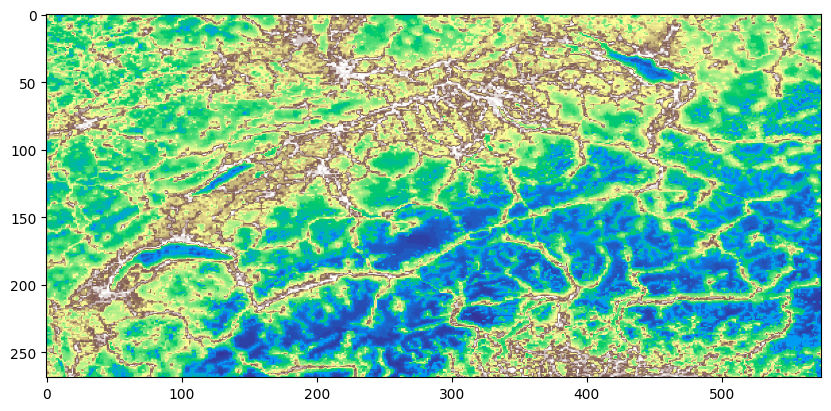

In [25]:
with rasterio.open("/home/pete/Documents/tests_and_vals/gdgtm/01_get_functions/olm_humfoot_switz_raw_20030101.tif") as target:
    target_data = target.read()
    
    plt.figure(figsize=(10, 10))
    plt.imshow(target_data[0], cmap='terrain') # For single-band raster
    # plt.imshow(data.transpose(1, 2, 0)) # For multi-band raster
    plt.show()

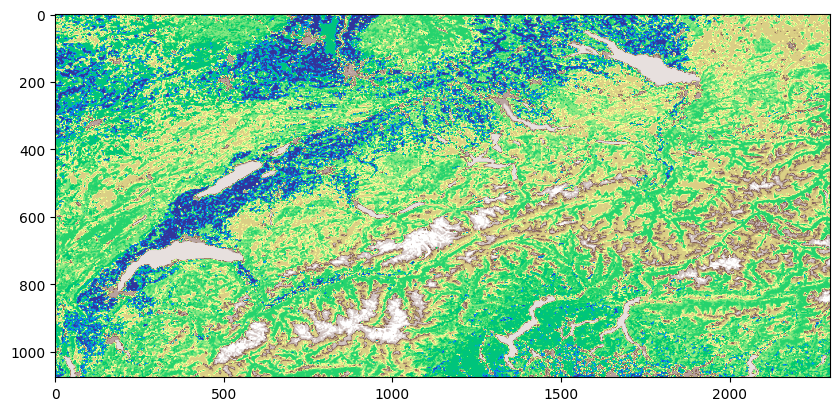

In [27]:
with rasterio.open("/home/pete/Documents/tests_and_vals/gdgtm/01_get_functions/olm_alc_switz_raw_20030101.tif") as target:
    target_data = target.read()
    
    plt.figure(figsize=(10, 10))
    plt.imshow(target_data[0], cmap='terrain') # For single-band raster
    # plt.imshow(data.transpose(1, 2, 0)) # For multi-band raster
    plt.show()

Reprojection successful
{'dimension_match': True, 'projection_match': True, 'pixel_count_match': True, 'geotransform_match': True}
Source file retained: False


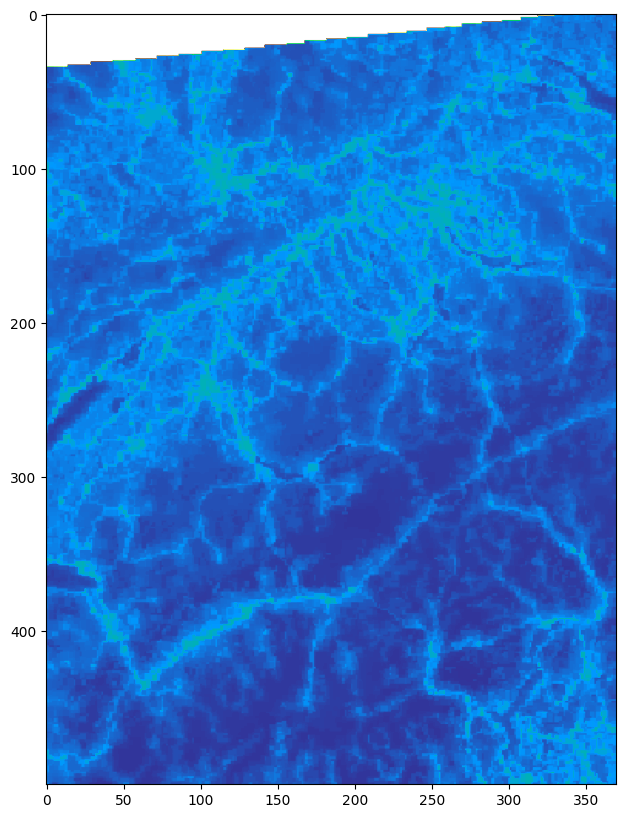

Reprojection successful
{'dimension_match': True, 'projection_match': True, 'pixel_count_match': True, 'geotransform_match': True}
Source file retained: False


Reprojection successful
{'dimension_match': True, 'projection_match': True, 'pixel_count_match': True, 'geotransform_match': True}
Source file retained: False


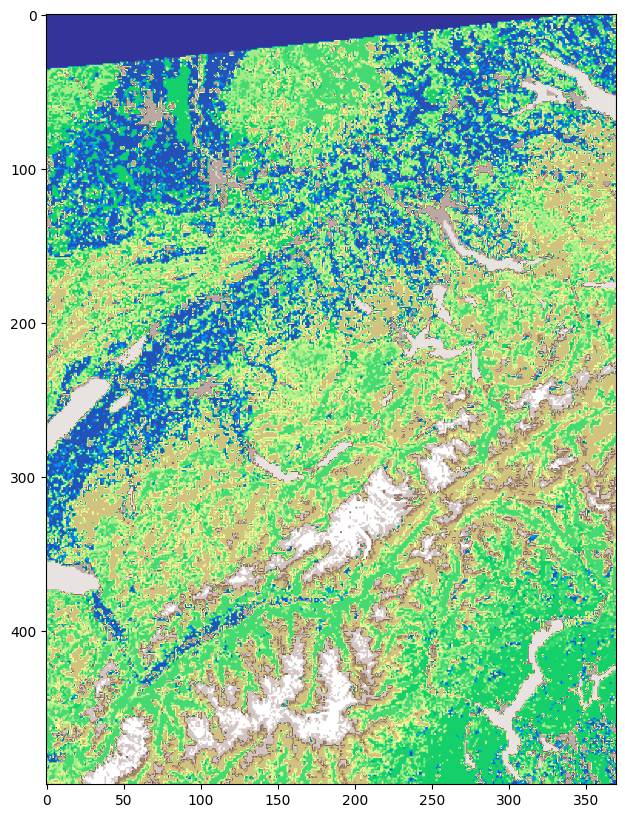

Reprojection successful
{'dimension_match': True, 'projection_match': True, 'pixel_count_match': True, 'geotransform_match': True}
Source file retained: False


In [28]:
rasters_to_process = [["/home/pete/Documents/tests_and_vals/gdgtm/01_get_functions/olm_humfoot_switz_raw_20030101.tif",
                      "/home/pete/Documents/tests_and_vals/gdgtm/05_supplements_aligned/olm_humfoot_switz_align_20030101.tif"],
                      ["/home/pete/Documents/tests_and_vals/gdgtm/01_get_functions/olm_humfoot_switz_raw_20040101.tif",
                      "/home/pete/Documents/tests_and_vals/gdgtm/05_supplements_aligned/olm_humfoot_switz_align_20040101.tif"],
                      ["/home/pete/Documents/tests_and_vals/gdgtm/01_get_functions/olm_alc_switz_raw_20030101.tif",
                      "/home/pete/Documents/tests_and_vals/gdgtm/05_supplements_aligned/olm_alc_switz_align_20030101.tif"],
                      ["/home/pete/Documents/tests_and_vals/gdgtm/01_get_functions/olm_alc_switz_raw_20040101.tif",
                      "/home/pete/Documents/tests_and_vals/gdgtm/05_supplements_aligned/olm_alc_switz_align_20040101.tif"]]




for raster in rasters_to_process:
    outcome = gdgtm.align_validate_raster(source_raster = raster[0],
                                          target_raster = "/home/pete/Documents/tests_and_vals/gdgtm/04_master_rebound/chelsa_tas_rebound.tif",
                                          dst_raster = raster[1])

    print(outcome)
    print("Source file retained: " + str(os.path.exists(raster[0])))
    with rasterio.open(raster[1]) as target:
        target_data = target.read()
    
        plt.figure(figsize=(10, 10))
        plt.imshow(target_data[0], cmap='terrain') # For single-band raster
        # plt.imshow(data.transpose(1, 2, 0)) # For multi-band raster
        plt.show()